# Pincell Depletion
This notebook is intended to introduce the reader to the depletion interface contained in OpenMC. It is recommended that you are moderately familiar with building models using the OpenMC Python API. The earlier examples are excellent starting points, as this notebook will not focus heavily on model building.

If you have a real power reactor, the fuel composition is constantly changing as fission events produce energy, remove some fissile isotopes, and produce fission products. Other reactions, like $(n, \alpha)$ and $(n, \gamma)$ will alter the composition as well. Furthermore, some nuclides undergo spontaneous decay with widely ranging frequencies. Depletion is the process of modeling this behavior.

In this notebook, we will model a simple fuel pin in an infinite lattice using the Python API. We will then build and examine some of the necessary components for performing depletion analysis. Then, we will use the depletion interface in OpenMC to simulate the fuel pin producing power over several months. Lastly, we will wrap up with some helpful tips to improve the fidelity of depletion simulations.

In [1]:
%matplotlib inline
import math
import openmc

## Build the Geometry

Much of this section is borrowed from the "Modeling a Pin-Cell" example. If you find yourself not understanding some aspects of this section, feel free to refer to that example, as some details may be glossed over for brevity.

First, we will create our fuel, cladding, and water materials to represent a typical PWR.

In [2]:
fuel = openmc.Material(name="uo2")
fuel.add_element("U", 1, percent_type="ao", enrichment=4.25)
fuel.add_element("O", 2)
fuel.set_density("g/cc", 10.4)

clad = openmc.Material(name="clad")
clad.add_element("Zr", 1)
clad.set_density("g/cc", 6)

water = openmc.Material(name="water")
water.add_element("O", 1)
water.add_element("H", 2)
water.set_density("g/cc", 1.0)
water.add_s_alpha_beta("c_H_in_H2O")
materials = openmc.Materials([fuel, clad, water])

Here, we are going to use the `openmc.model.pin` function to build our pin cell. The `pin` function anticipates concentric cylinders and materials to fill the inner regions. One additional material is needed than the number of cylinders to cover the domain outside the final ring. 

To do this, we define two radii for the outer radius of our fuel pin, and the outer radius of the cladding.

In [3]:
radii = [0.42, 0.45]

Using these radii, we define concentric `ZCylinder` objects. So long as the cylinders are concentric and increasing in radius, any orientation can be used. We also take advantage of the fact that the `openmc.Materials` object is a subclass of the `list` object to assign materials to the regions defined by the surfaces.

In [4]:
pin_surfaces = [openmc.ZCylinder(r=r) for r in radii]
pin_univ = openmc.model.pin(pin_surfaces, materials)

The first material, in our case `fuel`, is placed inside the first cylinder in the inner-most region. The second material, `clad`, fills the space between our cylinders, while `water` is placed outside the last ring. The `pin` function returns an `openmc.Universe` object, and has some additional features we will mention later. Finally, we need to place the fuel pin universe in a bounding cell.

In [5]:
bound_box = openmc.model.RectangularPrism(1.24, 1.24, boundary_type="reflective")
root_cell = openmc.Cell(fill=pin_univ, region=-bound_box)
geometry = openmc.Geometry([root_cell])

To ensure our geometry looks right, let's plot it.

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

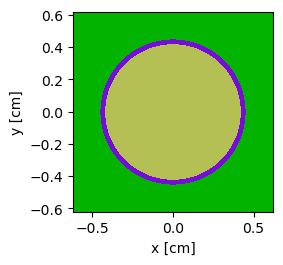

In [6]:
geometry.root_universe.plot()

Lastly we construct our settings. For the sake of time, a relatively low number of particles will be used.

In [7]:
settings = openmc.Settings()
settings.particles = 1000
settings.inactive = 10
settings.batches = 50

The depletion interface relies on `OpenMC` to perform the transport simulation and obtain reaction rates and other important information. Normally, we would need to export XML files before running OpenMC, but the depletion interface takes care of this for us.

However, we must first add one bit of information: the volume of our fuel. In order to translate the reaction rates obtained by `openmc` to meaningful units for depletion, we have to normalize them to a correct power. This requires us to know, or be able to calculate, how much fuel is in our problem. Correctly setting the volumes is a critical step, and can lead to incorrect answers, as the fuel is over- or under-depleted due to poor normalization.

For our problem, we can assign the "volume" to be the cross-sectional area of our fuel. This is identical to modeling our fuel pin inside a box with height of 1 cm.

In [8]:
fuel.volume = math.pi * radii[0] ** 2

## Setting up for depletion

The OpenMC depletion interface can be accessed from the `openmc.deplete` module, and has a variety of classes that will help us.

In [17]:
import openmc.deplete

In order to run the depletion calculation we need the following information:

1. Nuclide decay, fission yield, and reaction data
2. Operational power or power density
3. Desired depletion schedule
4. Desired time integration scheme

The first item is necessary to determine the paths by which nuclides transmute over the depletion simulation. This includes spontaneous decay, fission product yield distributions, and nuclides produced through neutron-reactions. For example,
* Te129 decays to I129 with a half life of ~70 minutes
* A fission event for U-235 produces fission products like Xe135 according to a distribution
* For thermal problems, Am241 will produce metastable Am242 about 8% of the time during an $(n,\gamma)$ reaction. The other 92% of capture reactions will produce ground state Am242

These data are often distributed with other nuclear data, like incident neutron cross sections with ENDF/B-VII.
OpenMC uses the [`openmc.deplete.Chain`](https://docs.openmc.org/en/latest/pythonapi/generated/openmc.deplete.Chain.html#openmc.deplete.Chain) to collect represent the various decay and transmutation pathways in a single object.
While a complete `Chain` can be created using nuclear data files, users may prefer to download pre-generated XML-representations instead.
Such files can be found at https://openmc.org/depletion-chains/ and include full and compressed chains, with capture branching ratios derived using PWR- or SFR-spectra.

For this problem, we will be using a much smaller depletion chain that contains very few nuclides. In a realistic problem, over 1000 isotopes may be included in the depletion chain.

In [28]:
chain = openmc.deplete.Chain.from_xml("./chain_simple.xml")
chain.nuclide_dict

OSError: Error reading file './chain_simple.xml': failed to load external entity "./chain_simple.xml"

The primary entry point for depletion is the `openmc.deplete.Operator`. It relies on the `openmc.deplete.Chain` and helper classes to run `openmc`, retrieve and normalize reaction rates, and other perform other tasks. For a thorough description, please see the full API documentation.

We will create our Operator using the geometry and settings from above, and our simple chain file. The materials are read in automatically using the `materials.xml` file.

In [16]:
model = openmc.Model(geometry=geometry, settings=settings)
operator = openmc.deplete.CoupledOperator(model, "./chain_simple.xml")

OSError: Error reading file './chain_simple.xml': failed to load external entity "./chain_simple.xml"

In [ ]:
power = 174

For this problem, we will take depletion step sizes of 30 days, and instruct OpenMC to re-run a transport simulation every 30 days until we have modeled the problem over a six month cycle. The depletion interface expects the time to be given in seconds, so we will have to convert. Note that these values are not cumulative.

In [ ]:
time_steps = [30] * 6

And lastly, we will use the basic predictor, or forward Euler, time integration scheme. Other, more advanced methods are provided to the user through `openmc.deplete`

In [ ]:
integrator = openmc.deplete.PredictorIntegrator(operator, time_steps, power, timestep_units='d')

To perform the simulation, we use the `integrate` method, and let `openmc` take care of the rest.

In [ ]:
integrator.integrate()

## Processing the outputs

The depletion simulation produces a few output files. First, the statepoint files from each individual transport simulation are written to `openmc_simulation_n<N>.h5`, where `<N>` indicates the current depletion step. Any tallies that we defined in `tallies.xml` will be included in these files across our simulations. We have 7 such files, one for each our of 6 depletion steps and the initial state.

In [ ]:
!ls *.h5

The `depletion_results.h5` file contains information that is aggregated over all time steps through depletion. This includes the multiplication factor, as well as concentrations. We can process this file using the `openmc.deplete.Results` object

In [ ]:
results = openmc.deplete.Results("./depletion_results.h5")

In [ ]:
time, k = results.get_keff()

In [ ]:
time /= (24 * 60 * 60)  # convert back to days from seconds

In [ ]:
k

The first column of `k` is the value of `k-combined` at each point in our simulation, while the second column contains the associated uncertainty. We can plot this using `matplotlib`

In [ ]:
from matplotlib import pyplot

In [ ]:
pyplot.errorbar(time, k[:, 0], yerr=k[:, 1])
pyplot.xlabel("Time [d]")
pyplot.ylabel("$k_{eff}\pm \sigma$");

Due to the low number of particles selected, the uncertainty on each value is rather high. However, we can still see the decline in `k` over time due to fuel consumption.

We can then examine concentrations of atoms in each of our materials. This requires knowing the material ID, which can be obtained from the `materials.xml` file.

In [ ]:
_, u235 = results.get_atoms("1", "U235")
_, xe135 = results.get_atoms("1", "Xe135")

In [ ]:
pyplot.plot(time, u235, label="U235")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - U235");

In [ ]:
pyplot.plot(time, xe135, label="Xe135")
pyplot.xlabel("Time [d]")
pyplot.ylabel("Number of atoms - Xe135");

We can also examine reaction rates over time using the `Results` object.

In [ ]:
_, u235_fission = results.get_reaction_rate("1", "U235", "fission")

In [ ]:
pyplot.plot(time, u235_fission)
pyplot.xlabel("Time [d]")
pyplot.ylabel("Fission reactions / s");

## Helpful tips

Depletion is a tricky task to get correct. Use too short of a time step, and you will incur a steep cost in computational time due to excessive transport simulations. Use too long of a time step, and you may miss physics happening on shorter timescales, leading to incorrect answers. Consider the xenon plot from above. Xenon-135 is a fission product with a thermal absorption cross section on the order of millions of barns, but it has a half life of ~9 hours. Taking smaller time steps at the beginning of your simulation to build up some equilibrium in your fission products is highly recommended.

When possible, differentiate materials that reappear in multiple places. If we had built an entire core with the single `fuel` material, every pin would be depleted using the same averaged spectrum and reaction rates, which is incorrect. Pins experiencing different flux will deplete at different rates. The `Operator` can differentiate these materials using the `diff_burnable_mats` argument, but note that the volumes will be copied from the original material.

Using higher-order integrators, like the `CECMIntegrator`, `EPCRK4Integrator` with a fourth order Runge-Kutta, or the `LEQIIntegrator`, can improve the accuracy of a simulation, or at least allow you to take longer depletion steps between transport simulations with similar accuracy.

Fuel pins with integrated burnable absorbers, like gadolinia, experience strong flux gradients until the absorbers are mostly burned away. This means that the spectrum and magnitude of the flux at the edge of the fuel pin can be vastly different than that in the interior. The helper `pin` function can be used to subdivide regions into equal volume segments, as follows.

In [19]:
div_surfs_1 = [openmc.ZCylinder(r=1)]
div_1 = openmc.model.pin(div_surfs_1, [fuel, water], subdivisions={0: 10})

In [ ]:
div_1.plot(width=(2.0, 2.0))

The innermost region has been divided into 10 equal volume regions. We can pass additional arguments to divide multiple regions, except for the region outside the last cylinder.

## Register depletion chain

The depletion chain we created can be registered into the OpenMC `cross_sections.xml` file, so we don't have to always pass the `chain_file` argument to the `Operator`. To do this, we create a `DataLibrary` using `openmc.data`. Without any arguments, the `from_xml` method will look for the file located at `OPENMC_CROSS_SECTIONS`. For this example, we will just create a bare library.

In [20]:
data_lib = openmc.data.DataLibrary()

In [26]:
data_lib.register_file("./chain_simple.xml")

In [27]:
data_lib.export_to_xml()

In [23]:
!cat cross_sections.xml

<?xml version='1.0' encoding='UTF-8'?>
<cross_sections>
  <depletion_chain path="chain_simple.xml" type="depletion_chain"/>
</cross_sections>


This allows us to make an `Operator` simply with the geometry and settings arguments, provided we exported our library to `OPENMC_CROSS_SECTIONS`. For a problem where we built and registered a `Chain` using all the available nuclear data, we might see something like the following.

In [29]:
model = openmc.Model(geometry=geometry, settings=settings)
new_op = openmc.deplete.CoupledOperator(model, "./chain_simple.xml")

OSError: Error reading file './chain_simple.xml': failed to load external entity "./chain_simple.xml"

In [ ]:
len(new_op.chain.nuclide_dict)

In [ ]:
[nuc.name for nuc in new_op.chain.nuclides[:10]]

In [ ]:
[nuc.name for nuc in new_op.chain.nuclides[-10:]]

## Choice of depletion step size

A general rule of thumb is to use depletion step sizes around 2 MWd/kgHM, where kgHM is really the initial heavy metal mass in kg. If your problem includes integral burnable absorbers, these typically require shorter time steps at or below 1 MWd/kgHM. These are typically valid for the predictor scheme, as the point of recent schemes is to extend this step size. A good convergence study, where the step size is decreased until some convergence metric is satisfied, is a beneficial exercise.

We can use the `Operator` to determine our maximum step size using this recommendation. The `heavy_metal` attribute returns the mass of initial heavy metal in g, which, using our power, can be used to compute this step size. $$\frac{2\,MWd}{kgHM} = \frac{P\times\Delta}{hm_{op}}$$

In [ ]:
operator.heavy_metal

In [ ]:
max_step = 2 * operator.heavy_metal / power * 1E3

In [ ]:
print("\"Maximum\" depletion step: {:5.3} [d]".format(max_step))

Alternatively, if we were provided the power density of our problem, we can provide this directly with `openmc.deplete.PredictorIntegrator(operator, time_steps, power_density=pdens)`. The values of `power` and `power_density` do not have to be scalars. For problems with variable power, we can provide an iterable with the same number of elements as `time_steps`.